In [75]:
# ---- Imports ----
import os
import numpy as np
import pandas as pd
import pymc as pm
import aesara.tensor as at
import arviz as az
import matplotlib.pyplot as plt

# (Optional) tame BLAS thread storms if you ever saw multiprocessing issues
# os.environ["OMP_NUM_THREADS"] = "1"
# os.environ["OPENBLAS_NUM_THREADS"] = "1"
# os.environ["MKL_NUM_THREADS"] = "1"
# os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
# os.environ["NUMEXPR_NUM_THREADS"] = "1"

# ---- User configuration ----
# Path to a CSV with time centers (ms) and counts per bin.
# If None, we'll simulate data.
CSV_PATH = "33Na_DecayTime_radius3.5_Ybw2.csv"   # e.g. "your_hist.csv"

# If your CSV lacks bin widths, set a scalar width here (ms)
DEFAULT_BIN_WIDTH_MS = 1.0

# Half-life priors in **linear ms** (mean ± sd). These are not Pn priors.
PARENT_T_MEAN_MS = 8
PARENT_T_SD_MS   = 40
DAUGH_T_MEAN_MS  = (90.2, 80.4, 270.0)
DAUGH_T_SD_MS    = ( 0.9,  0.4,   2.0)

# Include parent activity term?
INCLUDE_PARENT = True

# Sampling
DRAWS = 200
TUNE  = 200
CHAINS = 4
CORES  = 4          # keep 1 if your environment dislikes multiprocessing
RANDOM_SEED = 42
TARGET_ACCEPT = 0.9


In [76]:
import aesara.tensor as at
import numpy as np

def _gd_counts_two_step(a, b, N0, lam_p, lam_d, lam_g, coef):
    """
    Exact ∫ A_g(t) dt for chain P(λp) -> D(λd) -> G(λg) with zero initial D,G.
    coef = N0 * b_k * r_k  (branching product). Handles general distinct λ;
    near-equality is stabilized by a tiny ε in denominators.
    """
    eps = 1e-14
    # Coeffs for the 3 exponentials (Bateman, multiplied by λg and integrated)
    c1 = (lam_d * lam_g) / ((lam_d - lam_p + eps) * (lam_g - lam_p + eps))
    c2 = (lam_p * lam_g) / ((lam_p - lam_d + eps) * (lam_g - lam_d + eps))
    c3 = (lam_p * lam_d) / ((lam_p - lam_g + eps) * (lam_d - lam_g + eps))
    term1 = c1 * (at.exp(-lam_p * a) - at.exp(-lam_p * b))
    term2 = c2 * (at.exp(-lam_d * a) - at.exp(-lam_d * b))
    term3 = c3 * (at.exp(-lam_g * a) - at.exp(-lam_g * b))
    return coef * (term1 + term2 + term3)

def bin_integrated_counts_ms_ae_with_gd(
    c_ms, w_ms,
    N0_eff, parentT_ms, d0_ms, d1_ms, d2_ms, b_vec,
    bg_c0_ms, bg_c1_ms, bg_lambda_ms,
    # --- NEW: granddaughters ---
    include_gd=(False, False, False),
    gd0_ms=None, gd1_ms=None, gd2_ms=None,
    r_vec=(1.0, 1.0, 1.0),  # daughter→granddaughter branching factors (constants)
    include_parent=True,
):
    c = at.as_tensor_variable(c_ms); w = at.as_tensor_variable(w_ms)
    a = c - 0.5*w; bnd = c + 0.5*w
    ln2 = at.log(2.0)

    lam_p = ln2/parentT_ms
    lam0  = ln2/d0_ms
    lam1  = ln2/d1_ms
    lam2  = ln2/d2_ms

    # Parent (optional)
    parent_counts = N0_eff * (at.exp(-lam_p * a) - at.exp(-lam_p * bnd))
    counts = parent_counts if include_parent else at.zeros_like(c)

    # Daughters (modified Bateman, with λd→λp safe limit)
    def d_counts(lam_d, b_k):
        delta = lam_d - lam_p
        exp_pa, exp_pb = at.exp(-lam_p*a), at.exp(-lam_p*bnd)
        exp_da, exp_db = at.exp(-lam_d*a), at.exp(-lam_d*bnd)
        std = N0_eff*b_k*((lam_d/delta)*(exp_pa-exp_pb) - (lam_p/delta)*(exp_da-exp_db))
        deg = N0_eff*b_k*((lam_p*a+1.0)*exp_pa - (lam_p*bnd+1.0)*exp_pb)
        tol = 1e-12*(1+at.abs_(lam_p)+at.abs_(lam_d))
        return at.switch(at.lt(at.abs_(delta), tol), deg, std)

    counts += d_counts(lam0, b_vec[0])
    counts += d_counts(lam1, b_vec[1])
    counts += d_counts(lam2, b_vec[2])

    # Granddaughters (optional, exact two-step Bateman)
    inc0, inc1, inc2 = include_gd
    r0, r1, r2 = r_vec
    if inc0:
        lam_g0 = ln2 / gd0_ms
        counts += _gd_counts_two_step(a, bnd, N0_eff, lam_p, lam0, lam_g0, b_vec[0]*r0)
    if inc1:
        lam_g1 = ln2 / gd1_ms
        counts += _gd_counts_two_step(a, bnd, N0_eff, lam_p, lam1, lam_g1, b_vec[1]*r1)
    if inc2:
        lam_g2 = ln2 / gd2_ms
        counts += _gd_counts_two_step(a, bnd, N0_eff, lam_p, lam2, lam_g2, b_vec[2]*r2)

    # Background: c0 + c1 exp(-λ_bg t)
    lam_bg = bg_lambda_ms
    bg_counts = bg_c0_ms * w + bg_c1_ms * (at.exp(-lam_bg*a) - at.exp(-lam_bg*bnd)) / lam_bg

    return at.clip(counts + bg_counts, 1e-12, np.inf)


In [81]:
import numpy as np

def _ln_params_from_mean_sd(mean, sd, min_rel=0.15):
    mean = float(mean); sd = float(sd)
    if not np.isfinite(mean) or mean <= 0:
        mean, sd = 1e-6, 10.0
    rel = max(sd / max(mean, 1e-12), min_rel)
    sigma_log = float(np.sqrt(np.log(1.0 + rel**2)))
    mu_log = float(np.log(mean) - 0.5*sigma_log**2)
    return mu_log, sigma_log

def estimate_bg_priors_from_negative_bins(centers_ms, widths_ms, counts,
    exclude_last_ms=0.0, tail_frac=0.4, head_frac=0.3, min_bins=8,
    min_excess=0.05, inflate=1.25):
    """Preferable if you DO have t<0 bins; returns LogNormal (mu_log,sigma_log) for c0, c1 and tau."""
    c = np.asarray(centers_ms, float)
    w = np.asarray(widths_ms, float)
    y = np.asarray(counts, int)
    if w.ndim == 0: w = np.full_like(c, float(w))

    mask = (c < 0.0) & np.isfinite(y) & np.isfinite(w) & (w > 0)
    if exclude_last_ms > 0: mask &= (c < -float(exclude_last_ms))
    cneg, wneg, yneg = c[mask], w[mask], y[mask]
    if cneg.size < min_bins:
        raise ValueError(f"Not enough negative-time bins ({cneg.size} < {min_bins})")

    r = yneg / wneg
    idx = np.argsort(cneg)
    n_tail = max(1, int(tail_frac * len(idx)))
    tail_idx = idx[:n_tail]
    c0_hat = float(np.median(r[tail_idx]))
    mad = 1.4826 * np.median(np.abs(r[tail_idx] - np.median(r[tail_idx])))
    sd_c0 = float(max(mad, 1e-6))

    n_head = max(3, int(head_frac * len(idx)))
    head_idx = idx[-n_head:]
    r_excess = r[head_idx] - c0_hat
    use = r_excess > (min_excess * max(c0_hat, 1e-6))
    t_head = cneg[head_idx][use]
    z_head = np.log(r_excess[use])

    if t_head.size >= 3 and np.all(np.isfinite(z_head)):
        A = np.vstack([-t_head, np.ones_like(t_head)]).T
        theta, residuals, _, _ = np.linalg.lstsq(A, z_head, rcond=None)
        lam_hat, log_c1_hat = map(float, theta)
        c1_hat = float(np.exp(log_c1_hat))
        dof = max(1, t_head.size - 2)
        sigma2 = float(residuals[0] / dof) if residuals.size else 0.25
        cov = sigma2 * np.linalg.inv(A.T @ A)
        sd_log_c1 = float(np.sqrt(max(cov[1,1], 1e-6)))
        sd_lam = float(np.sqrt(max(cov[0,0], 1e-6)))
    else:
        lam_hat, sd_lam = 1.0 / max(np.percentile(-cneg, 75), 1.0), 1.0
        c1_hat, sd_log_c1 = 0.1 * max(c0_hat, 1e-6), 1.0

    mu_c0, sg_c0 = _ln_params_from_mean_sd(c0_hat, inflate * sd_c0)
    rel_c1 = float(np.sqrt(np.exp((inflate*sd_log_c1)**2) - 1.0))
    sd_c1 = max(rel_c1 * c1_hat, 0.1 * c1_hat)
    mu_c1, sg_c1 = _ln_params_from_mean_sd(max(c1_hat, 1e-12), sd_c1)

    tau_hat = 1.0 / max(lam_hat, 1e-12)
    sd_tau = sd_lam / (lam_hat**2 + 1e-12)
    mu_tau, sg_tau = _ln_params_from_mean_sd(tau_hat, inflate * sd_tau if np.isfinite(sd_tau) else tau_hat)

    return {
        "bg_c0_ms": (mu_c0, sg_c0),
        "bg_c1_ms": (mu_c1, sg_c1),
        "bg_tau_ms": (mu_tau, sg_tau),
    }

def estimate_bg_priors_from_positive_tail(centers_ms, widths_ms, counts,
    tail_frac=0.3, head_ms=10.0, inflate=1.5):
    """Fallback when you have no negative bins. Uses late-time tail for c0 and first head_ms after 0 for the exp."""
    c = np.asarray(centers_ms, float)
    w = np.asarray(widths_ms, float)
    y = np.asarray(counts, int)
    if w.ndim == 0: w = np.full_like(c, float(w))

    mask_pos = (c >= 0.0) & np.isfinite(y) & np.isfinite(w) & (w > 0)
    cpos, wpos, ypos = c[mask_pos], w[mask_pos], y[mask_pos]
    if cpos.size < 10:
        # very weak priors
        mu_c0, sg_c0 = _ln_params_from_mean_sd(1e-3, 10.0)
        mu_c1, sg_c1 = _ln_params_from_mean_sd(1e-3, 10.0)
        mu_tau, sg_tau = _ln_params_from_mean_sd(40.0, 40.0)
        return {"bg_c0_ms": (mu_c0, sg_c0), "bg_c1_ms": (mu_c1, sg_c1), "bg_tau_ms": (mu_tau, sg_tau)}

    rate = ypos / wpos
    # far tail for c0
    idx = np.argsort(cpos)
    n_tail = max(3, int(tail_frac * len(idx)))
    tail_idx = idx[-n_tail:]
    c0_hat = float(np.median(rate[tail_idx]))
    mad = 1.4826 * np.median(np.abs(rate[tail_idx] - np.median(rate[tail_idx])))
    sd_c0 = float(max(mad, 1e-6))
    mu_c0, sg_c0 = _ln_params_from_mean_sd(c0_hat, inflate * sd_c0)

    # near-zero window for exponential
    head_mask = (cpos <= (cpos.min() + head_ms))
    t_head = cpos[head_mask]
    r_excess = (rate[head_mask] - c0_hat)
    use = r_excess > 0.1 * max(c0_hat, 1e-6)
    if use.sum() >= 3:
        A = np.vstack([-t_head[use], np.ones(use.sum())]).T
        z = np.log(r_excess[use])
        theta, residuals, _, _ = np.linalg.lstsq(A, z, rcond=None)
        lam_hat, log_c1_hat = map(float, theta)
        c1_hat = float(np.exp(log_c1_hat))
        dof = max(1, use.sum() - 2)
        sigma2 = float(residuals[0] / dof) if residuals.size else 0.25
        cov = sigma2 * np.linalg.inv(A.T @ A)
        sd_log_c1 = float(np.sqrt(max(cov[1,1], 1e-6)))
        sd_lam = float(np.sqrt(max(cov[0,0], 1e-6)))
        tau_hat = 1.0 / max(lam_hat, 1e-12)
        sd_tau = sd_lam / (lam_hat**2 + 1e-12)
    else:
        c1_hat, sd_log_c1 = 0.5 * c0_hat, 1.0
        tau_hat, sd_tau = 40.0, 40.0

    rel_c1 = float(np.sqrt(np.exp((inflate*sd_log_c1)**2) - 1.0))
    sd_c1 = max(rel_c1 * c1_hat, 0.1 * c1_hat)
    mu_c1, sg_c1 = _ln_params_from_mean_sd(max(c1_hat, 1e-12), sd_c1)
    mu_tau, sg_tau = _ln_params_from_mean_sd(tau_hat, inflate * sd_tau)

    return {"bg_c0_ms": (mu_c0, sg_c0), "bg_c1_ms": (mu_c1, sg_c1), "bg_tau_ms": (mu_tau, sg_tau)}

def estimate_bg_priors(centers_ms, widths_ms, counts, require_neg_bins=False, **kw):
    """Try t<0 first; if none and require_neg_bins=False, fall back to positive-tail."""
    try:
        return estimate_bg_priors_from_negative_bins(centers_ms, widths_ms, counts, **kw)
    except Exception as e:
        if require_neg_bins:
            raise
        return estimate_bg_priors_from_positive_tail(centers_ms, widths_ms, counts)


In [103]:
import pymc as pm

def normal_to_lognormal(mu_lin, sigma_lin):
    sigma_log = np.sqrt(np.log(1.0 + (sigma_lin / mu_lin)**2))
    mu_log    = np.log(mu_lin) - 0.5 * sigma_log**2
    return float(mu_log), float(sigma_log)

def build_model_noPn_with_optional_gd(
    c, w, y,
    # parent & daughter HL (linear ms)
    parentT_mu_ms, parentT_sigma_ms,
    daughT_mu_ms,  daughT_sigma_ms,      # tuples (3,)
    # background same as before
    include_parent=True,
    # --- NEW: granddaughter options ---
    include_gd=(False, False, False),
    gdT_mu_ms=(100.0, 100.0, 100.0),     # linear ms means (placeholder)
    gdT_sigma_ms=(20.0, 20.0, 20.0),     # linear ms sd
    r_vec=(1.0, 1.0, 1.0),               # fixed daughter→granddaughter branching factors
):
    c = np.asarray(c, float); y = np.asarray(y, int); w = np.asarray(w, float)
    if w.ndim == 0: w = np.full_like(c, float(w))

    # HL priors → LogNormal params
    p_mu, p_sig   = normal_to_lognormal(parentT_mu_ms, parentT_sigma_ms)
    d0_mu, d0_sig = normal_to_lognormal(daughT_mu_ms[0], daughT_sigma_ms[0])
    d1_mu, d1_sig = normal_to_lognormal(daughT_mu_ms[1], daughT_sigma_ms[1])
    d2_mu, d2_sig = normal_to_lognormal(daughT_mu_ms[2], daughT_sigma_ms[2])

    # GD priors → LogNormal (only used if included)
    gd0_mu, gd0_sig = normal_to_lognormal(gdT_mu_ms[0], gdT_sigma_ms[0])
    gd1_mu, gd1_sig = normal_to_lognormal(gdT_mu_ms[1], gdT_sigma_ms[1])
    gd2_mu, gd2_sig = normal_to_lognormal(gdT_mu_ms[2], gdT_sigma_ms[2])

    with pm.Model() as m:
        # data
        c_data = pm.MutableData("c_ms", c)
        w_data = pm.MutableData("w_ms", w)

        # HL priors
        parentT = pm.LogNormal("parentT_ms", mu=p_mu, sigma=p_sig)
        # d0      = pm.LogNormal("daugh0nT_ms", mu=d0_mu, sigma=d0_sig)
        # d1      = pm.LogNormal("daugh1nT_ms", mu=d1_mu, sigma=d1_sig)
        d2      = pm.LogNormal("daugh2nT_ms", mu=d2_mu, sigma=d2_sig)
        base_mu, base_sd = 85.0, 10.0
        mu_log, sd_log = normal_to_lognormal(base_mu, base_sd)
        d_base = pm.LogNormal("d_base_ms", mu=mu_log, sigma=sd_log)
        delta  = pm.Normal("log_ratio_d0_d1", mu=np.log(90/81), sigma=0.15)
        d0 = pm.Deterministic("daugh0nT_ms", d_base * at.exp(+0.5*delta))
        d1 = pm.Deterministic("daugh1nT_ms", d_base * at.exp(-0.5*delta))
        # GD HLs (only used if included)
        if include_gd[0]:
            gd0 = pm.LogNormal("gd0nT_ms", mu=gd0_mu, sigma=gd0_sig)
        else:
            gd0 = pm.Deterministic("gd0nT_ms", at.as_tensor_variable(np.inf))  # dummy
        if include_gd[1]:
            gd1 = pm.LogNormal("gd1nT_ms", mu=gd1_mu, sigma=gd1_sig)
        else:
            gd1 = pm.Deterministic("gd1nT_ms", at.as_tensor_variable(np.inf))
        if include_gd[2]:
            gd2 = pm.LogNormal("gd2nT_ms", mu=gd2_mu, sigma=gd2_sig)
        else:
            gd2 = pm.Deterministic("gd2nT_ms", at.as_tensor_variable(np.inf))

        # amplitudes → detected fractions, no Pn prior
        #amp = pm.HalfNormal("amp", sigma=max(10.0, 5.0*(y.max()+1.0)), shape=3)
        



        # background (same as before)
        mean_per_bin = float(np.mean(y)) if y.size>0 else 1.0
        mean_w = float(np.mean(w)) if w.size>0 else 1.0
        # bg_c0 = pm.LogNormal("bg_c0_ms", mu=np.log(max(mean_per_bin/max(mean_w,1e-6), 1e-6)), sigma=3.0)
        # bg_c1 = pm.HalfNormal("bg_c1_ms", sigma=max(10.0, mean_per_bin/max(mean_w,1e-6)))

        # Estimate a plateau from late bins to set scale
        

        #bg_lam = pm.LogNormal("bg_lambda_ms", mu=np.log(1.0/max(mean_w,1.0)), sigma=2.0)
        # priors from the entire histogram (including negatives)
        pri = estimate_bg_priors(centers_all_ms, bin_width_ms, counts_all)

        # now build the model with t>=0 data only
        mask_pos = centers_all_ms >= -120
        centers_ms = centers_all_ms[mask_pos]
        counts     = counts_all[mask_pos]
        scale = max(1.0, counts.sum() / len(counts))   # rough mean per bin
        amp = pm.Exponential("amp", lam=1/scale, shape=3)
        b   = pm.Deterministic("b", amp / at.sum(amp))
        N0_eff = pm.Deterministic("N0_eff", at.sum(amp))
        (mu_c0, sg_c0) = pri["bg_c0_ms"]; (mu_c1, sg_c1) = pri["bg_c1_ms"]; (mu_tau, sg_tau) = pri["bg_tau_ms"]

        with pm.Model() as model:
            bg_c0 = pm.LogNormal("bg_c0_ms", mu=mu_c0, sigma=sg_c0)
            bg_c1 = pm.LogNormal("bg_c1_ms", mu=mu_c1, sigma=sg_c1)
            bg_tau = pm.LogNormal("bg_tau_ms", mu=mu_tau, sigma=sg_tau)
            bg_lam = pm.Deterministic("bg_lambda_ms", 1.0 / bg_tau)
            # ... rest unchanged ...



        # expected counts (exact)
        mu_counts = bin_integrated_counts_ms_ae_with_gd(
            c_ms=c_data, w_ms=w_data,
            N0_eff=N0_eff, parentT_ms=parentT,
            d0_ms=d0, d1_ms=d1, d2_ms=d2, b_vec=b,
            bg_c0_ms=bg_c0, bg_c1_ms=bg_c1, bg_lambda_ms=bg_lam,
            include_gd=include_gd, gd0_ms=gd0, gd1_ms=gd1, gd2_ms=gd2,
            r_vec=r_vec,
            include_parent=include_parent,
        )

        #pm.Poisson("y_obs", mu=mu_counts, observed=y)
        # phi = pm.HalfNormal("overdisp", sigma=5.0)     # larger phi → closer to Poisson
        # pm.NegativeBinomial("y_obs", mu=mu_counts, alpha=phi, observed=counts)

        # handy deterministics
        pm.Deterministic("b0n", b[0]); pm.Deterministic("b1n", b[1]); pm.Deterministic("b2n", b[2])
        pm.Deterministic("b_sum_1n2n", b[1] + b[2])

    return m


In [104]:
if CSV_PATH and os.path.exists(CSV_PATH):
    df = pd.read_csv(CSV_PATH)
    cols = {c.lower(): c for c in df.columns}
    # Try common names; change here to match your CSV
    xcol = cols.get("xval", cols.get("x_val", cols.get("bincenter", cols.get("t", None))))
    ycol = cols.get("yval", cols.get("y_val", cols.get("bincontent", cols.get("counts", None))))
    if xcol is None or ycol is None:
        raise ValueError("CSV must have columns for time centers and counts (e.g., xVal, yVal).")
    centers_ms = df[xcol].to_numpy(dtype=float)
    counts     = np.asarray(np.round(df[ycol].to_numpy(dtype=float)), dtype=int)

    # Keep only t >= 0 (no negative-time anchoring)
    m = centers_ms >= 0
    l=centers_ms>=-120
    centers_all_ms = centers_ms[l]
    counts_all = counts[l]
    centers_ms = centers_ms[m]
    counts     = counts[m]
    
    # Bin width: infer from center diffs if regular; else use default
    diffs = np.diff(centers_ms)
    if diffs.size > 0 and np.all(np.isfinite(diffs)):
        bin_width_ms = float(np.median(diffs))
    else:
        bin_width_ms = DEFAULT_BIN_WIDTH_MS

    print(f"Loaded {centers_ms.size} bins from {CSV_PATH}; using bin width = {bin_width_ms} ms")
else:
    # Simulated example (for demo/testing)
    rng = np.random.default_rng(123)
    bin_width_ms = 2.0
    t_max = 40.0
    centers_ms = np.arange(0.5*bin_width_ms, t_max, bin_width_ms)

    # ground truth (feel free to tweak)
    N0_true = 1e5
    parentT_true = 8
    d0_true, d1_true, d2_true = 90.2, 80.4, 270.0
    b_true = np.array([1,1,1])
    bg_c0_true = 2.0        # counts/ms
    bg_c1_true = 6000      # counts/ms at t=0
    bg_lambda_true = 30  # 1/ms

    ln2 = np.log(2.0)
    lam_p = ln2/parentT_true
    lam0  = ln2/d0_true
    lam1  = ln2/d1_true
    lam2  = ln2/d2_true
    a = centers_ms - 0.5*bin_width_ms
    b = centers_ms + 0.5*bin_width_ms

    parent_counts = N0_true * (np.exp(-lam_p*a) - np.exp(-lam_p*b))

    def d_counts(lam_d, bk):
        delta = lam_d - lam_p
        exp_pa, exp_pb = np.exp(-lam_p*a), np.exp(-lam_p*b)
        exp_da, exp_db = np.exp(-lam_d*a), np.exp(-lam_d*b)
        return N0_true*bk*((lam_d/delta)*(exp_pa-exp_pb) - (lam_p/delta)*(exp_da-exp_db))

    daughters = d_counts(lam0, b_true[0]) + d_counts(lam1, b_true[1]) + d_counts(lam2, b_true[2])
    bg_counts = bg_c0_true * bin_width_ms + bg_c1_true * (np.exp(-bg_lambda_true*a) - np.exp(-bg_lambda_true*b)) / bg_lambda_true

    mu = parent_counts + daughters + bg_counts
    counts = rng.poisson(mu).astype(int)
    print(f"Simulated {centers_ms.size} bins; bin width = {bin_width_ms} ms")


Loaded 50 bins from 33Na_DecayTime_radius3.5_Ybw2.csv; using bin width = 2.0 ms


In [105]:
with build_model_noPn_with_optional_gd(
    c=centers_all_ms, w=bin_width_ms, y=counts_all,
    parentT_mu_ms=8, parentT_sigma_ms=40,
    daughT_mu_ms=(90.2, 80.4, 270.0),
    daughT_sigma_ms=(0.9, 0.4, 2.0),
    include_parent=True,
    include_gd=(True, False, False),       # <-- only 1n granddaughter
    gdT_mu_ms=(41.5, 31.7, 100),       # set your linear ms means
    gdT_sigma_ms=(0.1,0.3, 100),       # and linear ms sds
    r_vec=(1.0, 1.0, 1.0),                 # daughter→granddaughter branch factors (fixed)
) as model:
    idata = pm.sample(200, tune=200, target_accept=0.95, chains=4, cores=4, random_seed=42)


Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [parentT_ms, daugh2nT_ms, d_base_ms, log_ratio_d0_d1, gd0nT_ms, amp, bg_c0_ms, bg_c1_ms, bg_tau_ms]


Sampling 4 chains for 200 tune and 200 draw iterations (800 + 800 draws total) took 7 seconds.
The acceptance probability does not match the target. It is 0.9951, but should be close to 0.95. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9971, but should be close to 0.95. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9955, but should be close to 0.95. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9964, but should be close to 0.95. Try to increase the number of tuning steps.


In [106]:
az.summary(
    idata,
    var_names=["b0n","b1n","b2n","b_sum_1n2n",
               "parentT_ms","daugh0nT_ms","daugh1nT_ms","daugh2nT_ms",
               "bg_c0_ms","bg_c1_ms","bg_lambda_ms", "amp","N0_eff"],
    kind="stats"
)


,mean,sd,hdi_3%,hdi_97%
b0n,0.346,0.234,0.006,0.756
b1n,0.333,0.241,0.000,0.771
b2n,0.321,0.236,0.000,0.750
b_sum_1n2n,0.654,0.234,0.244,0.994
parentT_ms,8.411,30.715,0.005,25.495
daugh0nT_ms,89.169,12.724,67.619,114.237
daugh1nT_ms,80.025,10.964,61.096,99.707
daugh2nT_ms,270.009,2.005,266.282,273.585
bg_c0_ms,5182.895,789.726,3725.397,6756.209
bg_c1_ms,511.252,1296.950,6.011,1629.219


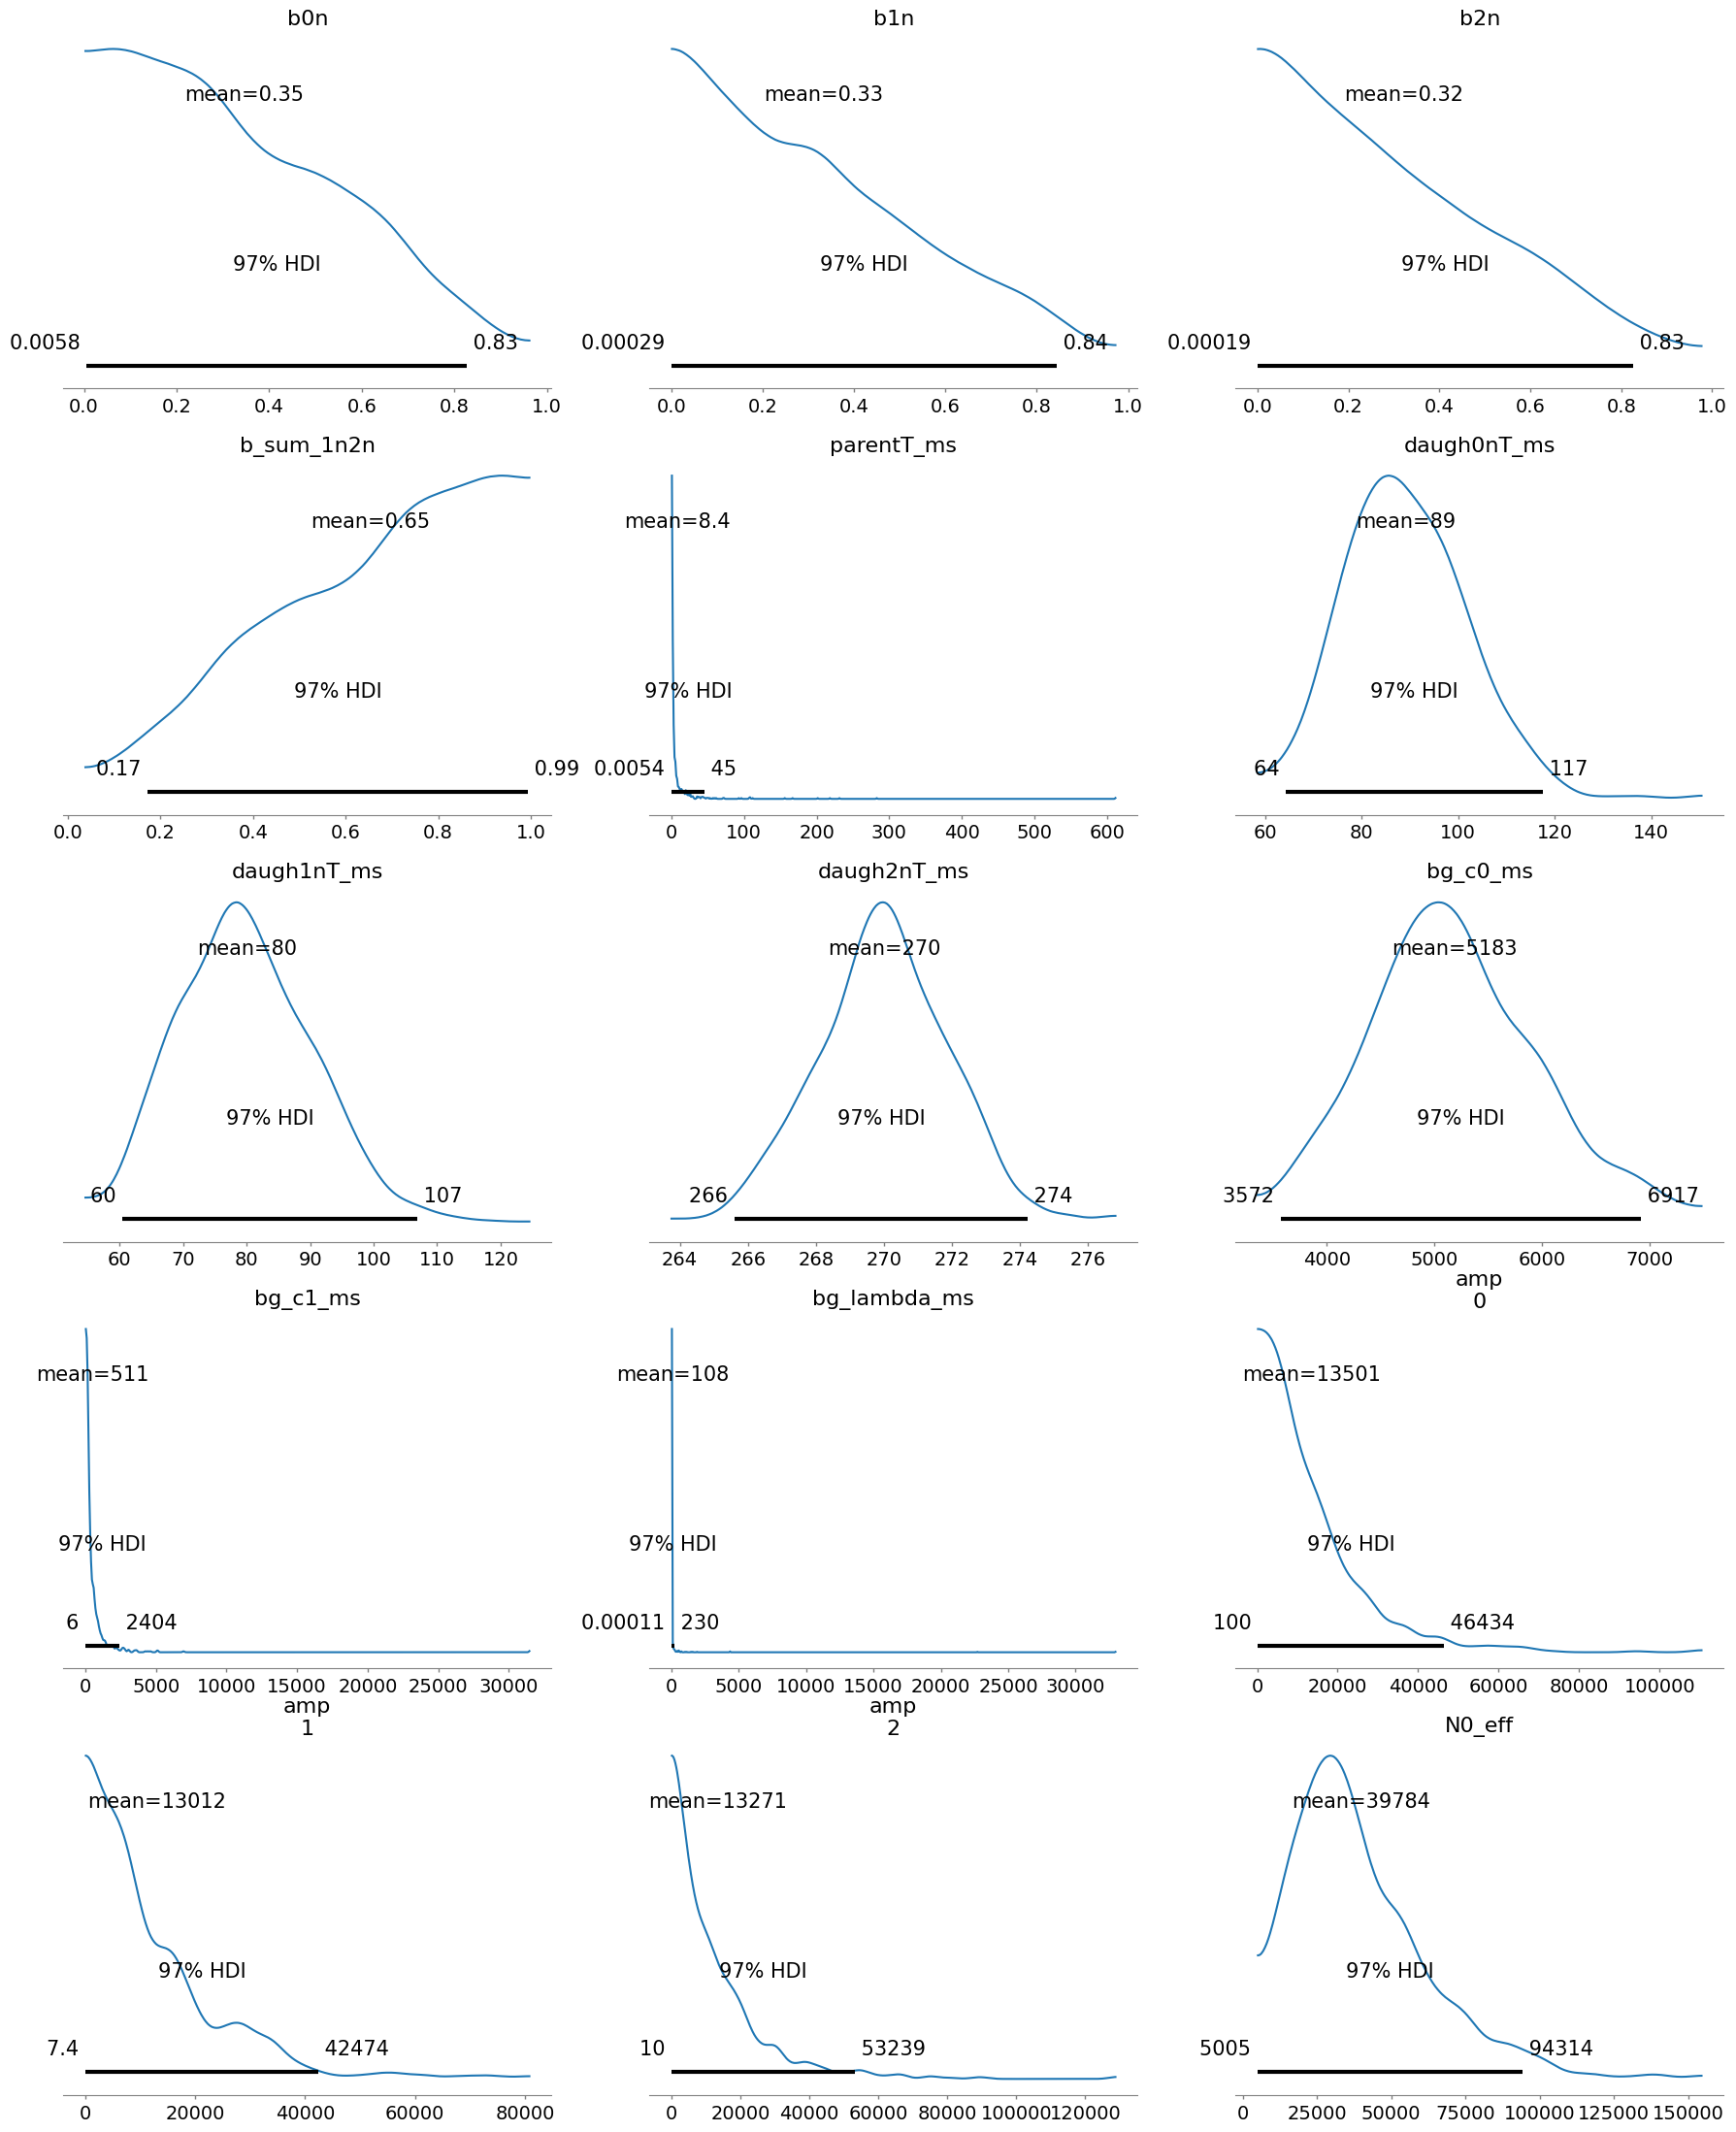

In [107]:
import arviz as az, matplotlib.pyplot as plt

pm.plot_posterior(
    idata,
    var_names=["b0n","b1n","b2n","b_sum_1n2n",
               "parentT_ms","daugh0nT_ms","daugh1nT_ms","daugh2nT_ms",
               "bg_c0_ms","bg_c1_ms","bg_lambda_ms", "amp","N0_eff"],
    hdi_prob=0.97
)
plt.show()
